# Gabor with color

In this notebook we will be loading already generated Gabors with colors and test with them. In another notebook we will include the generation of the Gabors to account for full customization of the experiment.

## Importing libraries

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

from perceptnet.networks import PerceptNet

## Loading the images

In [5]:
path_tests = '/media/disk/users/paherca/Perceptual_tests'
path_achromatic = 'gabors_without_noise_achromatic.npy'
path_rg = 'gabors_without_noise_red_green.npy'
path_yb = 'gabors_without_noise_yellow_blue.npy'

In [6]:
gabor_achromatic = np.load(os.path.join(path_tests, path_achromatic))
gabor_rg = np.load(os.path.join(path_tests, path_rg))
gabor_yb = np.load(os.path.join(path_tests, path_yb))

gabor_achromatic.shape, gabor_rg.shape, gabor_yb.shape

((256, 256, 3, 5, 8), (256, 256, 3, 5, 8), (256, 256, 3, 5, 8))

These files have (256,256,3) images created with 5 different frequencies (4th dim), and we have 8 different contrasts for each frequency (5th dim).

To be able to pass them through our model in a more confortable way we could transpose the so that the frequency and the contrast act as "batch dims".

The different freqs we have are: 2, 4, 8, 16, 32.

In [7]:
freqs = [2, 4, 8, 16, 32]
contrasts = 0.7*np.linspace(0, 0.15, 8)

In [8]:
gabor_achromatic = gabor_achromatic.transpose(3,4,0,1,2)
gabor_rg = gabor_rg.transpose(3,4,0,1,2)
gabor_yb = gabor_yb.transpose(3,4,0,1,2)

gabor_achromatic.shape, gabor_rg.shape, gabor_yb.shape

((5, 8, 256, 256, 3), (5, 8, 256, 256, 3), (5, 8, 256, 256, 3))

### Plotting the loaded images

We can plot the data to make sure everything is correct:

#### Achromatic

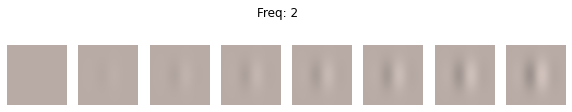

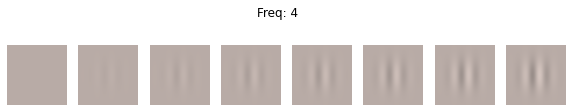

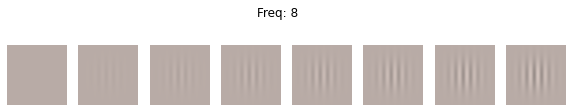

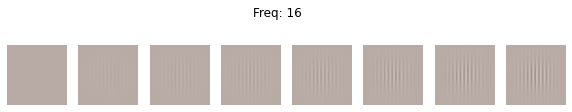

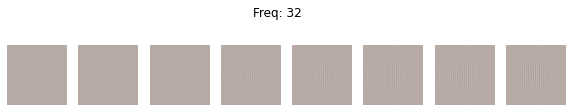

In [10]:
for i in range(len(freqs)):
    fig, ax = plt.subplots(1, 8, figsize=(10,2))
    for j,img in enumerate(gabor_achromatic[i]):
        ax[j].imshow(img)
        ax[j].axis('off')
    plt.suptitle(f'Freq: {freqs[i]}')
    plt.show()

#### Red-Green

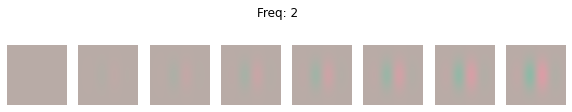

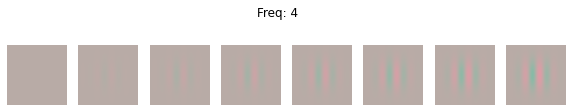

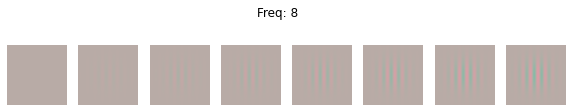

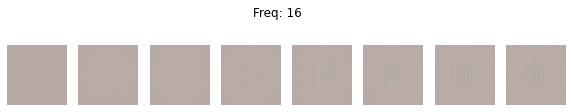

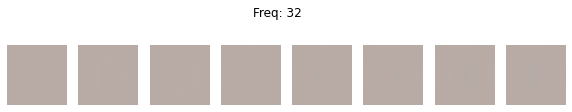

In [11]:
for i in range(len(freqs)):
    fig, ax = plt.subplots(1, 8, figsize=(10,2))
    for j,img in enumerate(gabor_rg[i]):
        ax[j].imshow(img)
        ax[j].axis('off')
    plt.suptitle(f'Freq: {freqs[i]}')
    plt.show()

#### Yellow-Blue

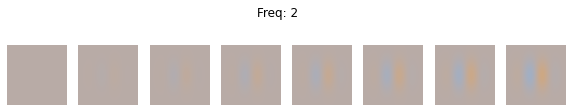

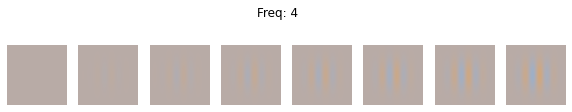

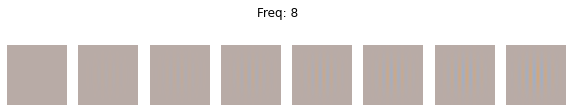

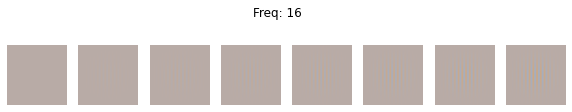

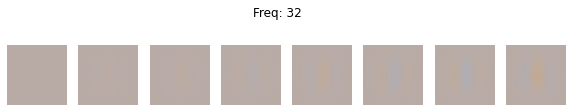

In [12]:
for i in range(len(freqs)):
    fig, ax = plt.subplots(1, 8, figsize=(10,2))
    for j,img in enumerate(gabor_yb[i]):
        ax[j].imshow(img)
        ax[j].axis('off')
    plt.suptitle(f'Freq: {freqs[i]}')
    plt.show()

## Passing the images through the network

In [13]:
weights_path = get_file(fname='perceptnet_rgb.h5',
                        origin='https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')

In [14]:
model = PerceptNet(kernel_initializer='ones', gdn_kernel_size=1, learnable_undersampling=False)
model.build(input_shape=(None, 384, 512, 3))
model.load_weights(weights_path)

2022-05-08 20:01:08.442424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


We can do the processing on the fly to save memory:

In [15]:
def get_readouts(model, imgs):
    ## Pass the through the model
    outputs = model.predict(imgs)

    ## Get the readouts as the distance to the lowest contrast image
    readouts = (outputs-outputs[0])**2
    readouts = np.sqrt(np.sum(readouts.reshape(imgs.shape[0],-1), axis=-1))
    
    ## Return readouts
    return readouts

In [24]:
NORM_INPUT = False # If true, the background of the achromatic turns brown-ish

In [37]:
results_achromatic = {}
for freq, batch in zip(freqs, gabor_achromatic):
    if NORM_INPUT:
        batch = (batch-batch.min())/(batch.max()-batch.min())
    results_achromatic[freq] = get_readouts(model, batch)

In [39]:
results_rg = {}
for freq, batch in zip(freqs, gabor_rg):
    if NORM_INPUT:
        batch = (batch-batch.min())/(batch.max()-batch.min())
    results_rg[freq] = get_readouts(model, batch)

In [38]:
results_yb = {}
for freq, batch in zip(freqs, gabor_yb):
    if NORM_INPUT:
        batch = (batch-batch.min())/(batch.max()-batch.min())
    results_yb[freq] = get_readouts(model, batch)

Plot the results:

In [41]:
def plot_results(results, color='k'):
    alphas = np.linspace(0.2,1,len(results))
    markers = ['o', '*', '^', 's', '.']
    for i, (freq, readouts) in enumerate(results.items()):
        plt.plot(contrasts, readouts, color, alpha=alphas[i], marker=markers[i], label=f'Freq = {freq}')
        plt.xlabel('Contrasts')
        plt.ylabel('Visibility')

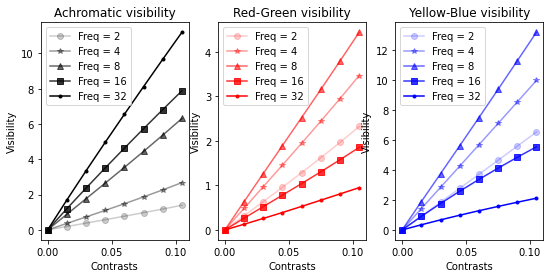

In [42]:
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
plt.title('Achromatic visibility')
plot_results(results_achromatic, color='k')
plt.legend()

plt.subplot(1,3,2)
plt.title('Red-Green visibility')
plot_results(results_rg, color='r')
plt.legend()

plt.subplot(1,3,3)
plt.title('Yellow-Blue visibility')
plot_results(results_yb, color='b')
plt.legend()

plt.show()

# CSF

We can calculate the CSFs from the visibility figures by taking the derivative of the curves:

In [43]:
results_achromatic_arr = np.array([a for a in results_achromatic.values()])
results_rg_arr = np.array([a for a in results_rg.values()])
results_yb_arr = np.array([a for a in results_yb.values()])

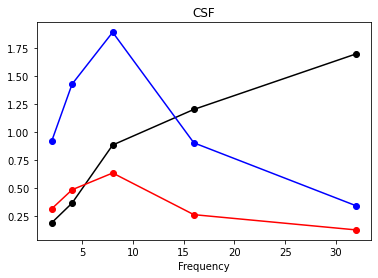

In [44]:
plt.figure()
plt.title('CSF')
plt.plot(freqs, results_achromatic_arr[:,1], 'k-o')
plt.plot(freqs, results_rg_arr[:,1], 'r-o')
plt.plot(freqs, results_yb_arr[:,1], 'b-o')
plt.xlabel('Frequency')
plt.show()